# Base CNN model from NVIDIA paper


In [1]:
import copy
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim
import torchvision.transforms as transforms
from torchsummary import summary

from utils import dataset
from models import nvidia_2

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm
import sigopt

LEARNING_RATE = 0.0001 # 0.00002  #0.000001  # 0.000007  # 0.0000007 for batchsize=1
# MOMENTUM = 0.4  # maybe decrease this below 0.5
WEIGHT_DECAY_REGULARIZATION_TERM = 0.003 # 0.001 
BATCH_SIZE = 1
NUM_EPOCHS = 15


# Citation:
# - AverageMeter taken verbatim from the Assignment 2 training code.
# - Remainder of code in this file based on Assignment 2 training code.
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(epoch, data_loader, model, optimizer, criterion, scaler=None):
    iter_time = AverageMeter()
    losses = AverageMeter()
    

    # Get the progress bar for later modification
    progress_bar = tqdm_notebook(data_loader, ascii=True)

    for idx, (data, target) in enumerate(progress_bar):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        # Forward pass and computation of loss.
        with torch.autocast("cuda"): #Automatic Mixed precision
            out = model(data).reshape(target.shape)
            # MSE loss
            loss = criterion(out, target)

        
        # Backwards pass to determine gradients and update model parameters.
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

        for param in model.parameters():
            param.grad = None
        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()
        losses.update(loss, out.shape[0])

        iter_time.update(time.time() - start)
        # if idx % 5 == 0:
        #     print(('Epoch: [{0}][{1}/{2}]\t'
        #            'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t'
        #            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           .format(epoch, idx, len(data_loader), iter_time=iter_time, loss=losses)))

        progress_bar.set_description_str(f"Epoch {epoch}, Batch: {idx+1}, Loss: {loss.item():.4f}")
            # "Batch: %d, Loss: %.4f" % ((idx + 1), loss.item()))
        
    return losses.avg

def validate(epoch, validation_loader, model, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()

    # Get the progress bar for later modification
    progress_bar = tqdm_notebook(validation_loader, ascii=True)

    for idx, (data, target) in enumerate(progress_bar):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        out = None
        loss = None

        with torch.no_grad():
            out = model(data)
            # MSE loss
            loss = criterion(out, target)

        # loss.squeeze()
        losses.update(loss, out.shape[0])

        iter_time.update(time.time() - start)

#         if idx % 10 == 0:
#             print(('Epoch: [{0}][{1}/{2}]\t'
#                    'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t')
#                   .format(epoch, idx, len(validation_loader), iter_time=iter_time, loss=losses))

        progress_bar.set_description_str(f"Batch: {idx+1}, Loss: {loss.item():.4f}")
           
        
        # progress_bar.set_description_str(
        #     "Batch: %d, Loss: %.4f" % ((idx + 1), loss.item()))

    print("* Average Loss @1: {loss.avg:.4f}".format(loss=losses))
    return losses.avg

def test(testing_loader, model, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()

    # Get the progress bar for later modification
    progress_bar = tqdm_notebook(testing_loader, ascii=True)

    for idx, (data, target) in enumerate(progress_bar):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        out = None
        loss = None

        with torch.inference_mode():   #no_grad():
            out = model(data)
            # MSE loss
            loss = criterion(out, target)

        losses.update(loss, out.shape[0])

        iter_time.update(time.time() - start)

        progress_bar.set_description_str(f"Batch: {idx+1}, Loss: {loss.item():.4f}")

    print("* Average Loss MSE @1: {loss.avg:.4f}".format(loss=losses))
    return torch.sqrt(losses.avg)


# RSME Loss function. eps prevents [nan] in the backward pass
def RSMELoss(yhat, y, eps=1e-6):
    return torch.sqrt(torch.mean((yhat-y)**2) + eps)

def plots(losses, lr=LEARNING_RATE, reg=WEIGHT_DECAY_REGULARIZATION_TERM, batch=BATCH_SIZE): #, momentum=MOMENTUM):
    fig1, ax1 = plt.subplots(figsize=(8, 10))
    ax1.plot(losses[0], label='Training Losses')
    ax1.plot(losses[1], label='Validation Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title(f'CNN Loss Curve w/Adam; LR={lr}; Reg={reg}; Batch={batch}')
    ax1.legend(loc="best")
    plt.grid()
    plt.savefig('CNN_2_Adam.png')
    plt.show()



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 61, 61]           2,960
         LeakyReLU-2           [-1, 20, 61, 61]               0
         MaxPool2d-3           [-1, 20, 60, 60]               0
       BatchNorm2d-4           [-1, 20, 60, 60]              40
            Conv2d-5           [-1, 25, 28, 28]          18,025
         LeakyReLU-6           [-1, 25, 28, 28]               0
         MaxPool2d-7           [-1, 25, 27, 27]               0
       BatchNorm2d-8           [-1, 25, 27, 27]              50
            Conv2d-9           [-1, 40, 12, 12]          25,040
        LeakyReLU-10           [-1, 40, 12, 12]               0
        MaxPool2d-11           [-1, 40, 11, 11]               0
      BatchNorm2d-12           [-1, 40, 11, 11]              80
           Conv2d-13             [-1, 55, 8, 8]          35,255
        LeakyReLU-14             [-1, 5

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0498


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:113: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6762 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


* Average Loss @1: 0.0488
Best performing model so far average validation loss: 0.0488 on epoch 0



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0345


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0461
Best performing model so far average validation loss: 0.0461 on epoch 1


Crossover condition met



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0318


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0272
Best performing model so far average validation loss: 0.0272 on epoch 2



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0300


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0298
Epoch 00004: reducing learning rate of group 0 to 1.0000e-05.
Best performing model so far average validation loss: 0.0272 on epoch 2



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0210


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0175
Best performing model so far average validation loss: 0.0175 on epoch 4



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0153


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0146
Best performing model so far average validation loss: 0.0146 on epoch 5



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0121


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0123
Best performing model so far average validation loss: 0.0123 on epoch 6



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0092


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0087
Best performing model so far average validation loss: 0.0087 on epoch 7



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0072


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0074
Best performing model so far average validation loss: 0.0074 on epoch 8



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0059


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0067
Best performing model so far average validation loss: 0.0067 on epoch 9



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0050


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0063
Best performing model so far average validation loss: 0.0063 on epoch 10



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0045


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0050
Best performing model so far average validation loss: 0.0050 on epoch 11



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0041


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0046
Best performing model so far average validation loss: 0.0046 on epoch 12



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0039


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0054
Epoch 00014: reducing learning rate of group 0 to 1.0000e-06.
Best performing model so far average validation loss: 0.0046 on epoch 12



  0%|          | 0/27046 [00:00<?, ?it/s]

Average training loss this epoch: 0.0028


  0%|          | 0/6762 [00:00<?, ?it/s]

* Average Loss @1: 0.0035
Best performing model so far average validation loss: 0.0035 on epoch 14

Best Training Loss @1: 0.0035

Best Model:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:154: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5614 [00:00<?, ?it/s]

* Average Loss MSE @1: 0.0191
Test Loss RMSE @1: 0.13836958647264547

Crossover Model:


  0%|          | 0/5614 [00:00<?, ?it/s]

* Average Loss MSE @1: 0.0246
Test Loss RMSE @1: 0.15671567399887884


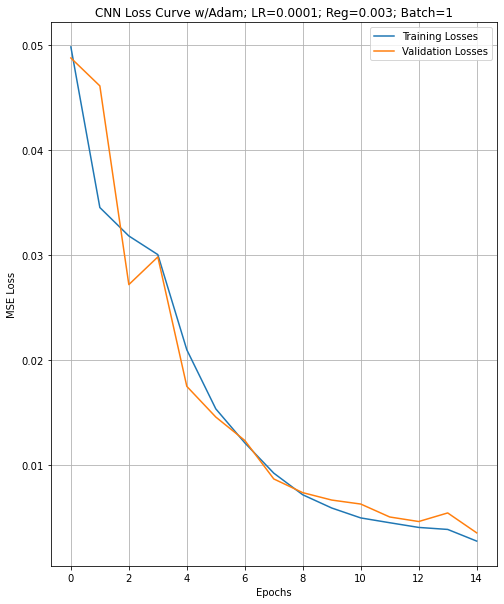

In [2]:
# !! Skip this cell for sigopt experimentation !!
def main():
    # Normalizing images per the paper and resizing each image to 66 x 200.
    transform = transforms.Compose([
        # Citation:
        # https://pytorch.org/vision/stable/transforms.html#scriptable-transforms
        transforms.Resize((128, 128)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
    ])

    # Loading in images with normalization and resizing applied.
    training_set, validation_set, testing_set = dataset.load_nvidia_dataset(transform=transform, batch_size=BATCH_SIZE)
    torch.cuda.empty_cache()

    # Loading in the NVIDIA DAVE-2 model.
    model = nvidia_2.NvidiaDaveCNN_2()

    if torch.cuda.is_available():
        model = model.to(torch.device("cuda"))

    print(summary(model, (3, 128, 128)))

    # Specify Mean Squared Error (MSE) or RSME as the criterion since this is a regression task.
    criterion = nn.MSELoss()
    # criterion = RMSELoss

    # Using Stochastic Gradient Descent (SGD) as the optimizer.
    optimizer = torch.optim.Adam(model.parameters(), 
                                LEARNING_RATE,
                                # MOMENTUM,
                                weight_decay=WEIGHT_DECAY_REGULARIZATION_TERM)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, verbose=True) 
    # torch.backends.cudnn.benchmark = True

    best = float('inf')
    best_model = None
    best_epoch = None
    train_losses = []
    valid_losses = []
    scaler = torch.cuda.amp.GradScaler()
    crossover_flag = False
    crossover_model = None
    for epoch in range(NUM_EPOCHS):

        # Training.
        train_loss = train(epoch, training_set, model, optimizer, criterion, scaler=scaler)
        temp = train_loss
        temp.cpu()
        temp = float(temp)
        train_losses.append(temp)  # average losses
        print(f"Average training loss this epoch: {temp:.4f}")

        # Validation.
        valid_loss = validate(epoch, validation_set, model, criterion)
        temp = valid_loss
        temp.cpu()
        temp = float(temp)
        valid_losses.append(temp)

        scheduler.step(valid_loss)

        if valid_loss < best:
            best = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        print(f"Best performing model so far average validation loss: {best:.4f} on epoch {best_epoch}\n")
        
        if not crossover_flag and valid_losses[-1] > train_losses[-1]:
            crossover_flag = True
            crossover_model = copy.deepcopy(best_model)
            print('\nCrossover condition met\n')
            torch.save(crossover_model.state_dict(), './checkpoints/jts_nvidia_dave2_crossover.pth')

    print('Best Training Loss @1: {:.4f}'.format(best))

    torch.save(best_model.state_dict(), './checkpoints/jts_nvidia_dave2.pth')

    # Testing the best models.
    print('\nBest Model:')
    test_loss = test(testing_set, best_model, criterion)
    print(f'Test Loss RMSE @1: {test_loss}')
    
    if crossover_model is not None:
        print('\nCrossover Model:')
        test_loss = test(testing_set, crossover_model, criterion)
        print(f'Test Loss RMSE @1: {test_loss}')
    
    losses_to_plot = train_losses, valid_losses
    plots(losses_to_plot, 
          lr=LEARNING_RATE, 
          reg=WEIGHT_DECAY_REGULARIZATION_TERM,
          batch=BATCH_SIZE, 
          # momentum=MOMENTUM  # not necessary for ADAM
         )

    

if __name__ == '__main__':
    main()

In [ ]:
def evaluate(args):       
        
    # log source of hyperparameter suggestion
    sigopt.log_metadata('optimizer', "Adam")
    sigopt.log_model("CNN - NVIDIA inspired")
    sigopt.log_dataset("Udacity self-driving dataset ")
    
    sigopt.params.setdefault("learning_rate", args['learning_rate'])
    sigopt.params.setdefault("reg", args['reg'])
    sigopt.params.setdefault("batch_size", int(args['batch_size']))
    
    # Normalizing images per the paper and resizing each image to 66 x 200.
    transform = transforms.Compose([
        # Citation:
        # https://pytorch.org/vision/stable/transforms.html#scriptable-transforms
        transforms.Resize((224, 224)),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        # transforms.RandomRotation(degrees=2)
    ])

    print("Params : ", sigopt.params)
    # Loading in images with normalization and resizing applied.
    training_set, validation_set = dataset.load_nvidia_dataset(transform=transform, batch_size=int(sigopt.params.batch_size))
    torch.cuda.empty_cache()

    # Loading in the NVIDIA DAVE-2 model.
    model = nvidia_2.NvidiaDaveCNN_2()

    if torch.cuda.is_available():
        model = model.to(torch.device("cuda"))


    # Specify Mean Squared Error (MSE) as criterion since this is a regression task. (We ultimately take sqrt and convert it to RMSE)
    criterion = nn.MSELoss()

    # Using Stochastic Gradient Descent (SGD) as the optimizer.
    optimizer = torch.optim.Adam(model.parameters(), sigopt.params.learning_rate,
                                weight_decay=sigopt.params.reg)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True) 
    # torch.backends.cudnn.benchmark = True

    best = float('inf')
    best_model = None
    best_epoch = None
    train_losses = []
    valid_losses = []
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):

        # Training.
        train_loss = train(epoch, training_set, model, optimizer, criterion, scaler=scaler)
        temp = train_loss
        temp.cpu()
        temp = float(temp)
        train_losses.append(temp)  # average losses
        print(f"Average training loss this epoch: {temp:.4f}")

        # Validation.
        valid_loss = validate(epoch, validation_set, model, criterion)  # JTS - changed from test to validation
        temp = valid_loss
        temp.cpu()
        temp = float(temp)
        valid_losses.append(temp)

        # scheduler.step(train_loss)  # JTS - this may or may not interfere with sigopt

        if valid_loss < best:
            best = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        print(f"Best performing model so far average validation loss: {best:.4f} on epoch {best_epoch}\n")

    print('Best Validation Loss @1: {:.4f}'.format(best))

    torch.save(best_model.state_dict(), './checkpoints/nvidia_dave2.pth')
    sigopt.log_metric(name='MSE', value=best)
    return best.cpu().numpy()

In [12]:
import os
os.environ["SIGOPT_API_TOKEN"] = "XWBIVDWCVQXALUZQFDHNGOELLLKDJBMOJALEPCNQXQGBNIGC"
os.environ['SIGOPT_PROJECT'] = 'nvidia_cnn'
%reload_ext sigopt
args = {
    'batch_size': 32,
    'learning_rate': 0.005,
    # 'momentum': 0.9,  # not necessary for ADAM
    'reg': 0.0005
}

In [16]:
%%experiment
{
    'name': 'GCP NVIDIA CNN model Optimization 4',
    'metrics': [
        {
            'name': 'MSE',
            'strategy': 'optimize',
            'objective': 'minimize',
        }
    ],
    'parameters': [
        {
            'name': 'reg',
            'type': 'double',
            'bounds': {'min': 0.0001, 'max': 0.5},
            'transformation': 'log'
        },
        {
            'name': 'learning_rate',
            'type': 'double',
            'bounds': {'min': 0.0001, 'max': 0.9},
            'transformation': 'log'
        },
        {
            'name': 'batch_size',
            'type': 'categorical',
            'categorical_values': ['32', '64']
        }
    ],
    'budget': 50
}

Experiment created, view it on the SigOpt dashboard at https://app.sigopt.com/experiment/530502


In [17]:
%%optimize gcp_nvidia_cnn_optimization_run_4
evaluate(args)

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/443907
Params :  {'learning_rate': 0.018230363908128745, 'batch_size': '64', 'reg': 0.0008720609512752354}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:112: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/106 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


* Average Loss @1: 0.0709
Best performing model so far average validation loss: 0.0709 on epoch 0



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0709
Best performing model so far average validation loss: 0.0709 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0709
Best performing model so far average validation loss: 0.0709 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0709
Best performing model so far average validation loss: 0.0709 on epoch 3



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0709
Best performing model so far average validation loss: 0.0709 on epoch 3

Best Training Loss @1: 0.0709
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/443907
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/444077
Params :  {'batch_size': '32', 'learning_rate': 0.00025388111084780133, 'reg': 0.04765246332354775}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0718


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0804
Best performing model so far average validation loss: 0.0804 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0688


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0790
Best performing model so far average validation loss: 0.0790 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0689


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0772
Best performing model so far average validation loss: 0.0772 on epoch 2



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0731


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0769
Best performing model so far average validation loss: 0.0769 on epoch 3



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0730


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0769
Best performing model so far average validation loss: 0.0769 on epoch 4

Best Training Loss @1: 0.0769
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/444077
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/444264
Params :  {'reg': 0.0005272268225859176, 'learning_rate': 0.7134881025056684, 'batch_size': '32'}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 34202864.5150


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 11890627092470866903040.0000
Best performing model so far average validation loss: 11890627092470866903040.0000 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 34265717.0084


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 11883849091945601171456.0000
Best performing model so far average validation loss: 11883849091945601171456.0000 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 34236751.1348


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 11855942193712409346048.0000
Best performing model so far average validation loss: 11855942193712409346048.0000 on epoch 2



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 34255920.8216


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 11910976162671135555584.0000
Best performing model so far average validation loss: 11855942193712409346048.0000 on epoch 2



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 34237862.7241


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 11899939502109726081024.0000
Best performing model so far average validation loss: 11855942193712409346048.0000 on epoch 2

Best Training Loss @1: 11855942193712409346048.0000
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/444264
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/444451
Params :  {'learning_rate': 0.007553313536995135, 'reg': 0.1329966022205953, 'batch_size': '32'}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0738


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0744
Best performing model so far average validation loss: 0.0744 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0737


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0744
Best performing model so far average validation loss: 0.0744 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0737


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0744
Best performing model so far average validation loss: 0.0744 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0737


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0745
Best performing model so far average validation loss: 0.0744 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0737


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0753
Best performing model so far average validation loss: 0.0744 on epoch 1

Best Training Loss @1: 0.0744
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/444451
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/444629
Params :  {'reg': 0.0007035963531847655, 'learning_rate': 0.009593277880234343, 'batch_size': '64'}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.5095
Best performing model so far average validation loss: 0.5095 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.5095
Best performing model so far average validation loss: 0.5095 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.5095
Best performing model so far average validation loss: 0.5095 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.5095
Best performing model so far average validation loss: 0.5095 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.5095
Best performing model so far average validation loss: 0.5095 on epoch 4

Best Training Loss @1: 0.5095
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/444629
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/444799
Params :  {'reg': 0.0004599567574657335, 'batch_size': '64', 'learning_rate': 0.014772097543530914}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 1425.1371
Best performing model so far average validation loss: 1425.1371 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 1430.4717
Best performing model so far average validation loss: 1425.1371 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 1424.6259
Best performing model so far average validation loss: 1424.6259 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 1431.0008
Best performing model so far average validation loss: 1424.6259 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 1420.9196
Best performing model so far average validation loss: 1420.9196 on epoch 4

Best Training Loss @1: 1420.9196
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/444799
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/444976
Params :  {'learning_rate': 0.009065370749114841, 'reg': 0.0011099402464313823, 'batch_size': '32'}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.7618
Best performing model so far average validation loss: 0.7618 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.7618
Best performing model so far average validation loss: 0.7618 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.7618
Best performing model so far average validation loss: 0.7618 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.7618
Best performing model so far average validation loss: 0.7618 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.7618
Best performing model so far average validation loss: 0.7618 on epoch 0

Best Training Loss @1: 0.7618
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/444976
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/445150
Params :  {'reg': 0.0005929757866880466, 'learning_rate': 0.029201383841976538, 'batch_size': '32'}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 38042506.9348
Best performing model so far average validation loss: 38042506.9348 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 38053252.8533
Best performing model so far average validation loss: 38042506.9348 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 38087126.8629
Best performing model so far average validation loss: 38042506.9348 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 38144168.0146
Best performing model so far average validation loss: 38042506.9348 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 38060143.7712
Best performing model so far average validation loss: 38042506.9348 on epoch 0

Best Training Loss @1: 38042506.9348
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/445150
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/445334
Params :  {'reg': 0.14280090723486485, 'learning_rate': 0.0028654375439597537, 'batch_size': '32'}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0796


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0690
Best performing model so far average validation loss: 0.0690 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0749


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0690
Best performing model so far average validation loss: 0.0690 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0750


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0690
Best performing model so far average validation loss: 0.0690 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0749


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0690
Best performing model so far average validation loss: 0.0690 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0750


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0691
Best performing model so far average validation loss: 0.0690 on epoch 0

Best Training Loss @1: 0.0690
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/445334
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/445520
Params :  {'learning_rate': 0.0006892811923412726, 'batch_size': '64', 'reg': 0.06698899511649309}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0741


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0733
Best performing model so far average validation loss: 0.0733 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0738


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0733
Best performing model so far average validation loss: 0.0733 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0738


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0733
Best performing model so far average validation loss: 0.0733 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0738


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0733
Best performing model so far average validation loss: 0.0733 on epoch 3



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0738


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0733
Best performing model so far average validation loss: 0.0733 on epoch 3

Best Training Loss @1: 0.0733
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/445520
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/445712
Params :  {'batch_size': '64', 'reg': 0.00040030229649861814, 'learning_rate': 0.00010758708461306807}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0486


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1061
Best performing model so far average validation loss: 0.1061 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0251


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1250
Best performing model so far average validation loss: 0.1061 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0138


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1286
Best performing model so far average validation loss: 0.1061 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0097


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1264
Best performing model so far average validation loss: 0.1061 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0076


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1343
Best performing model so far average validation loss: 0.1061 on epoch 0

Best Training Loss @1: 0.1061
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/445712
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/445890
Params :  {'batch_size': '32', 'learning_rate': 0.000795985914865582, 'reg': 0.00010566931443326124}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0507


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1229
Best performing model so far average validation loss: 0.1229 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0334


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1141
Best performing model so far average validation loss: 0.1141 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0256


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1399
Best performing model so far average validation loss: 0.1141 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0240


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1053
Best performing model so far average validation loss: 0.1053 on epoch 3



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0179


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1217
Best performing model so far average validation loss: 0.1053 on epoch 3

Best Training Loss @1: 0.1053
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/445890
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/446064
Params :  {'batch_size': '64', 'learning_rate': 0.00013904476526628112, 'reg': 0.5}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0865


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0833
Best performing model so far average validation loss: 0.0833 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0803


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0751
Best performing model so far average validation loss: 0.0751 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0759


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0727
Best performing model so far average validation loss: 0.0727 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0746


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0720
Best performing model so far average validation loss: 0.0720 on epoch 3



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0743


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0718
Best performing model so far average validation loss: 0.0718 on epoch 4

Best Training Loss @1: 0.0718
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/446064
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/446239
Params :  {'batch_size': '64', 'learning_rate': 0.00046675296107294634, 'reg': 0.00013601077923175155}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0415


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1316
Best performing model so far average validation loss: 0.1316 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0239


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1221
Best performing model so far average validation loss: 0.1221 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0145


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1339
Best performing model so far average validation loss: 0.1221 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0116


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1275
Best performing model so far average validation loss: 0.1221 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0076


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1419
Best performing model so far average validation loss: 0.1221 on epoch 1

Best Training Loss @1: 0.1221
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/446239
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/446418
Params :  {'learning_rate': 0.0006947940381421509, 'batch_size': '32', 'reg': 0.16753266012635545}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0743


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0727
Best performing model so far average validation loss: 0.0727 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0740


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0727
Best performing model so far average validation loss: 0.0727 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0740


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0727
Best performing model so far average validation loss: 0.0727 on epoch 2



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0740


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0727
Best performing model so far average validation loss: 0.0727 on epoch 3



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0740


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0727
Best performing model so far average validation loss: 0.0727 on epoch 3

Best Training Loss @1: 0.0727
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/446418
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/446589
Params :  {'reg': 0.3454693992376663, 'learning_rate': 0.014610826492620613, 'batch_size': '64'}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0742


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0743
Best performing model so far average validation loss: 0.0743 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0739


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0741
Best performing model so far average validation loss: 0.0741 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0738


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0740
Best performing model so far average validation loss: 0.0740 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0738


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0741
Best performing model so far average validation loss: 0.0740 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0739


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0740
Best performing model so far average validation loss: 0.0740 on epoch 2

Best Training Loss @1: 0.0740
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/446589
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/446765
Params :  {'batch_size': '32', 'learning_rate': 0.00010787139805185393, 'reg': 0.00011189621138379568}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0475


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1079
Best performing model so far average validation loss: 0.1079 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0218


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1159
Best performing model so far average validation loss: 0.1079 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0116


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1151
Best performing model so far average validation loss: 0.1079 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0077


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1216
Best performing model so far average validation loss: 0.1079 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0062


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1221
Best performing model so far average validation loss: 0.1079 on epoch 0

Best Training Loss @1: 0.1079
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/446765
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/446942
Params :  {'learning_rate': 0.01652395156278354, 'reg': 0.0017779648434006526, 'batch_size': '32'}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.3494
Best performing model so far average validation loss: 0.3494 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.3494
Best performing model so far average validation loss: 0.3494 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.3494
Best performing model so far average validation loss: 0.3494 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.3494
Best performing model so far average validation loss: 0.3494 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.3494
Best performing model so far average validation loss: 0.3494 on epoch 1

Best Training Loss @1: 0.3494
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/446942
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/447115
Params :  {'learning_rate': 0.0035227565620396836, 'batch_size': '64', 'reg': 0.5}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0771


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0707
Best performing model so far average validation loss: 0.0707 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0746


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0705
Best performing model so far average validation loss: 0.0705 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0746


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0706
Best performing model so far average validation loss: 0.0705 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0746


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0705
Best performing model so far average validation loss: 0.0705 on epoch 3



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0745


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0705
Best performing model so far average validation loss: 0.0705 on epoch 3

Best Training Loss @1: 0.0705
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/447115
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/447293
Params :  {'reg': 0.00391369506452751, 'batch_size': '64', 'learning_rate': 0.0002474048690739496}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0556


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1100
Best performing model so far average validation loss: 0.1100 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0443


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1067
Best performing model so far average validation loss: 0.1067 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0336


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1261
Best performing model so far average validation loss: 0.1067 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0276


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1141
Best performing model so far average validation loss: 0.1067 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0241


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1207
Best performing model so far average validation loss: 0.1067 on epoch 1

Best Training Loss @1: 0.1067
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/447293
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/447471
Params :  {'reg': 0.5, 'batch_size': '32', 'learning_rate': 0.0001}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0928


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0953
Best performing model so far average validation loss: 0.0953 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0898


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0860
Best performing model so far average validation loss: 0.0860 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0821


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0795
Best performing model so far average validation loss: 0.0795 on epoch 2



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0768


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0755
Best performing model so far average validation loss: 0.0755 on epoch 3



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0743


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0743
Best performing model so far average validation loss: 0.0743 on epoch 4

Best Training Loss @1: 0.0743
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/447471
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/447644
Params :  {'learning_rate': 0.019695512462225936, 'reg': 0.0001, 'batch_size': '32'}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 217930711.4941
Best performing model so far average validation loss: 217930711.4941 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 217881524.9862
Best performing model so far average validation loss: 217881524.9862 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 217837954.1920
Best performing model so far average validation loss: 217837954.1920 on epoch 2



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 217726525.7700
Best performing model so far average validation loss: 217726525.7700 on epoch 3



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 217757695.3290
Best performing model so far average validation loss: 217726525.7700 on epoch 3

Best Training Loss @1: 217726525.7700
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/447644
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/447780
Params :  {'batch_size': '64', 'reg': 0.0001, 'learning_rate': 0.0014993386242399586}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0810


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0781
Best performing model so far average validation loss: 0.0781 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0728


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0780
Best performing model so far average validation loss: 0.0780 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0718


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0880
Best performing model so far average validation loss: 0.0780 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0553


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0966
Best performing model so far average validation loss: 0.0780 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0441


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.1121
Best performing model so far average validation loss: 0.0780 on epoch 1

Best Training Loss @1: 0.0780
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/447780
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/447952
Params :  {'batch_size': '32', 'learning_rate': 0.003080041338447943, 'reg': 0.0001}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.2540


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0737
Best performing model so far average validation loss: 0.0737 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0738


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0737
Best performing model so far average validation loss: 0.0737 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0739


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0740
Best performing model so far average validation loss: 0.0737 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0739


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0740
Best performing model so far average validation loss: 0.0737 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0740


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0738
Best performing model so far average validation loss: 0.0737 on epoch 1

Best Training Loss @1: 0.0737
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/447952
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/448157
Params :  {'reg': 0.004280725436972789, 'learning_rate': 0.001528219754039935, 'batch_size': '32'}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0685


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0916
Best performing model so far average validation loss: 0.0916 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0554


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0849
Best performing model so far average validation loss: 0.0849 on epoch 1



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0525


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0843
Best performing model so far average validation loss: 0.0843 on epoch 2



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0540


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0776
Best performing model so far average validation loss: 0.0776 on epoch 3



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0517


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0963
Best performing model so far average validation loss: 0.0776 on epoch 3

Best Training Loss @1: 0.0776
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/448157
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/448377
Params :  {'batch_size': '32', 'learning_rate': 0.0001, 'reg': 0.019477546248408372}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0613


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0826
Best performing model so far average validation loss: 0.0826 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0567


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0897
Best performing model so far average validation loss: 0.0826 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0549


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0930
Best performing model so far average validation loss: 0.0826 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0538


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0904
Best performing model so far average validation loss: 0.0826 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0527


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.0907
Best performing model so far average validation loss: 0.0826 on epoch 0

Best Training Loss @1: 0.0826
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/448377
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/448582
Params :  {'reg': 0.027204703957656423, 'batch_size': '64', 'learning_rate': 0.012473186837404643}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 24622.0710
Best performing model so far average validation loss: 24622.0710 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 24591.3463
Best performing model so far average validation loss: 24591.3463 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 24597.7143
Best performing model so far average validation loss: 24591.3463 on epoch 1



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 24563.2854
Best performing model so far average validation loss: 24563.2854 on epoch 3



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: nan


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 24617.5350
Best performing model so far average validation loss: 24563.2854 on epoch 3

Best Training Loss @1: 24563.2854
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/448582
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/448788
Params :  {'learning_rate': 0.0002549502503996142, 'batch_size': '32', 'reg': 0.00016393850349765592}


  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0453


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1007
Best performing model so far average validation loss: 0.1007 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0224


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1289
Best performing model so far average validation loss: 0.1007 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0151


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1320
Best performing model so far average validation loss: 0.1007 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0098


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1294
Best performing model so far average validation loss: 0.1007 on epoch 0



  0%|          | 0/846 [00:00<?, ?it/s]

Average training loss this epoch: 0.0079


  0%|          | 0/212 [00:00<?, ?it/s]

* Average Loss @1: 0.1308
Best performing model so far average validation loss: 0.1007 on epoch 0

Best Training Loss @1: 0.1007
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/448788
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/449001
Params :  {'reg': 0.03978362716630089, 'learning_rate': 0.0018808754891849926, 'batch_size': '64'}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0751


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0765
Best performing model so far average validation loss: 0.0765 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0731


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0765
Best performing model so far average validation loss: 0.0765 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0731


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0766
Best performing model so far average validation loss: 0.0765 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0731


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0764
Best performing model so far average validation loss: 0.0764 on epoch 3



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0731


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0764
Best performing model so far average validation loss: 0.0764 on epoch 4

Best Training Loss @1: 0.0764
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/449001
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/449214
Params :  {'batch_size': '64', 'learning_rate': 0.0001, 'reg': 0.10336652425114365}


  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0748


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0759
Best performing model so far average validation loss: 0.0759 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0761


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0767
Best performing model so far average validation loss: 0.0759 on epoch 0



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0768


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0744
Best performing model so far average validation loss: 0.0744 on epoch 2



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0752


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0736
Best performing model so far average validation loss: 0.0736 on epoch 3



  0%|          | 0/423 [00:00<?, ?it/s]

Average training loss this epoch: 0.0747


  0%|          | 0/106 [00:00<?, ?it/s]

* Average Loss @1: 0.0733
Best performing model so far average validation loss: 0.0733 on epoch 4

Best Training Loss @1: 0.0733
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/449214
